In [2]:
# GENERAL PACKAGE IMPORT
import sys
sys.path.append('/Users/huangwp/Documents/git/HIL-Sim/flexlab/db_layer')
# ----------------------
from db_interface import DB_Interface
import requests
import numpy as np
import json
import pandas as pd
from pandas import DataFrame
from io import StringIO

import datetime as dt
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.dates import date2num
import seaborn
import timeit
import json
import pickle

import matplotlib.pyplot as plt
#import oa_temp as oa
#import sa_temp as sa
import db_plotting

In [3]:
data24 = pd.read_csv('data24_revised.csv', parse_dates = True, index_col = 0)
data25 = pd.read_csv('data25_revised.csv', parse_dates = True, index_col = 0)

data24['datetime'] = pd.to_datetime(data24['datetime'])
data25['datetime'] = pd.to_datetime(data25['datetime'])

In [4]:
print(data24.columns)

Index(['desk1_plug_power', 'desk2_plug_power', 'desk3_plug_power',
       'desk4_plug_power', 'desk5_plug_power', 'desk6_plug_power',
       'desk3_light_power', 'desk4_light_power', 'desk2_light_power',
       'desk1_6_light_power', 'desk5_light_power', '1A-VAV1-Zn_Temp',
       '1A-VAV2-Zn_Temp', '1A-VAV3-Zn_Temp', '1A-VAV1-OccupiedCoolingSetpt',
       '1A-VAV1-UnoccupiedCoolingSetpt', '1A-VAV1-OccupiedHeatingSetpt',
       '1A-VAV1-UnoccupiedHeatingSetpt', '1A-VAV2-OccupiedCoolingSetpt',
       '1A-VAV2-UnoccupiedHeatingSetpt', '1A-VAV2-UnoccupiedCoolingSetpt',
       '1A-VAV2-OccupiedHeatingSetpt', '1A-VAV3-OccupiedCoolingSetpt',
       '1A-VAV3-UnoccupiedHeatingSetpt', '1A-VAV3-UnoccupiedCoolingSetpt',
       '1A-VAV3-OccupiedHeatingSetpt', '1A-El-AHU', '1A-El-CHWP', '1A-El-HWP',
       '1A-El-Exhaust Fan', '1A-Th-Chilled Water', '1B-OAT-1',
       '1A-MidZone-TCS6-DBT', '1A-NorthZone-DBT', '1A-WindowZone-TCS7-DBT',
       '1A-VAV1-DischargeAirTemp', '1A-VAV2-DischargeAirTemp',
 

In [5]:
data24['precool_window'] = 0
data24['gta_window'] = 0

data25['precool_window'] = 0
data25['gta_window'] = 0

precool_st = datetime.time(10,0,0)
precool_en = datetime.time(14,0,0)

gta_st = datetime.time(14,0,0)
gta_en = datetime.time(18,0,0)

print(type(data24['datetime'].iloc[0]))
print(type(datetime.time(14,0,0)))

data24['date'] = data24['datetime'].apply(lambda x: datetime.date(x.year, x.month, x.day))
data24['time'] = data24['datetime'].apply(lambda x: datetime.time(x.hour, x.minute, x.second))

data25['date'] = data25['datetime'].apply(lambda x: datetime.date(x.year, x.month, x.day))
data25['time'] = data25['datetime'].apply(lambda x: datetime.time(x.hour, x.minute, x.second))

gta_ts = (data24['time'] >= gta_st) & (data24['time'] <= gta_en)
precool_ts = (data24['time'] >= precool_st) & (data24['time'] <= precool_en)

#print(gta_ts)
data24['precool_window'][precool_ts] = 1
data24['gta_window'][gta_ts] = 1

data25['precool_window'][precool_ts] = 1
data25['gta_window'][gta_ts] = 1

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'datetime.time'>


/var/folders/31/7jjh3bzd6_d_tmg49kbcdsb40000gp/T/ipykernel_1373/3869486426.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data24['precool_window'][precool_ts] = 1
/var/folders/31/7jjh3bzd6_d_tmg49kbcdsb40000gp/T/ipykernel_1373/3869486426.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data24['gta_window'][gta_ts] = 1
/var/folders/31/7jjh3bzd6_d_tmg49kbcdsb40000gp/T/ipykernel_1373/3869486426.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

### Metrics

In [6]:
data24 = data24.assign(COP='COP') 
#data24['COP'] = data24['oat_C'].apply(lambda x: (0.548 + 0.0951*x + (-7.63E-04)*x**2))
data24['COP'] = 2.9

data25 = data25.assign(COP='COP') 
#data25['COP'] = data25['oat_C'].apply(lambda x: (0.548 + 0.0951*x + (-7.63E-04)*x**2))
data25['COP'] = 2.9

In [7]:
data24 = data24.assign(chiller = 'Chiller_load') 
data24['Chiller_load'] = (data24['1A-Th-Chilled Water']/data24['COP'])*-1
data24['cooling_power [W]'] = data24['1A-El-AHU'] + data24['1A-El-Exhaust Fan'] + data24['1A-El-CHWP'] + data24['Chiller_load']

data25 = data25.assign(chiller = 'Chiller_load') 
data25['Chiller_load'] = (data25['1B-Th-Chilled Water']/data25['COP'])*-1
data25['cooling_power [W]'] = data25['1B-El-AHU'] + data25['1B-El-Exhaust Fan'] + data25['1B-El-CHWP'] + data25['Chiller_load']

In [8]:
en_1a = []
en_1b = []
# define dates for the calculation
for day in range(15, 20):    
    mask_1 = data24['date'] == datetime.date(2021, 9, day)
    print(day)
    day_en_1a = round((data24['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1a.append(day_en_1a)
    
    day_en_1b = round((data25['cooling_power [W]'][mask_1].sum()/4000),2)
    #print(day_en_1b)
    en_1b.append(day_en_1b)

15
16
17
18
19


In [9]:
test_day_mask = (((data25['date'] >= datetime.date(2021, 9, 15)) & (data25['date'] <= datetime.date(2021, 9, 19))))

In [10]:
data24 = data24[test_day_mask]
data25 = data25[test_day_mask]

/Users/huangwp/Documents/git/HIL-Sim/flexlab/test_data_analysis/db_plotting.py:38: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace = .2, wspace=.15)


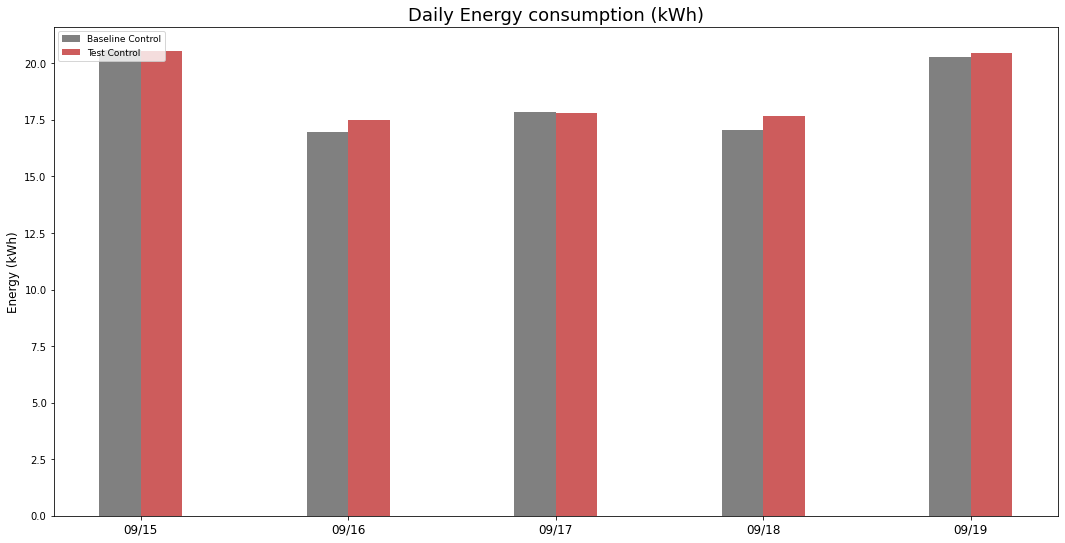

In [11]:
db_plotting.energy_plot(data25, en_1a, en_1b, 'Daily Energy consumption (kWh)', 'Energy (kWh)')

In [12]:
print(en_1b)

[20.56, 17.47, 17.8, 17.65, 20.46]


### Shed

In [13]:
data25['G36 Demand Shed'] = data25['cooling_power [W]'] - data24['cooling_power [W]']

shed_1a = []
shed_1b = []
shed_oat = []
# define dates for the calculation
for day in range(15,20):    
    mask_1 = data24['date'] == datetime.date(2021, 9, day)   # days in range,analyze by each day
    #print(day) 
    day_shed_1a = (data24['cooling_power [W]'][mask_1][gta_ts].mean())  # only select 2-6pm
    shed_1a.append(day_shed_1a)
    
    day_shed_1b = (data25['cooling_power [W]'][mask_1][gta_ts].mean())
    shed_1b.append(day_shed_1b)
    
    shed_oat_mean=(data24['1B-OAT-1'][mask_1][gta_ts].mean())  # outdoor air temperature average from 2-6pm
    
    shed_oat.append(shed_oat_mean) # make daily average temp a list



In [14]:
shed_oat

[17.45450588235294,
 16.228323529411764,
 17.962600000000002,
 17.15485882352941,
 21.074305882352945]

[839.1100297035274, 771.1036852812822, 831.7791331815941, 781.6152274588288, 949.6061529028864]
['09/15', '09/16', '09/17', '09/18', '09/19']
[839.1100297035274, 771.1036852812822, 831.7791331815941, 781.6152274588288, 949.6061529028864]


/Users/huangwp/Documents/git/HIL-Sim/flexlab/test_data_analysis/db_plotting.py:71: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace = .2, wspace=.15)


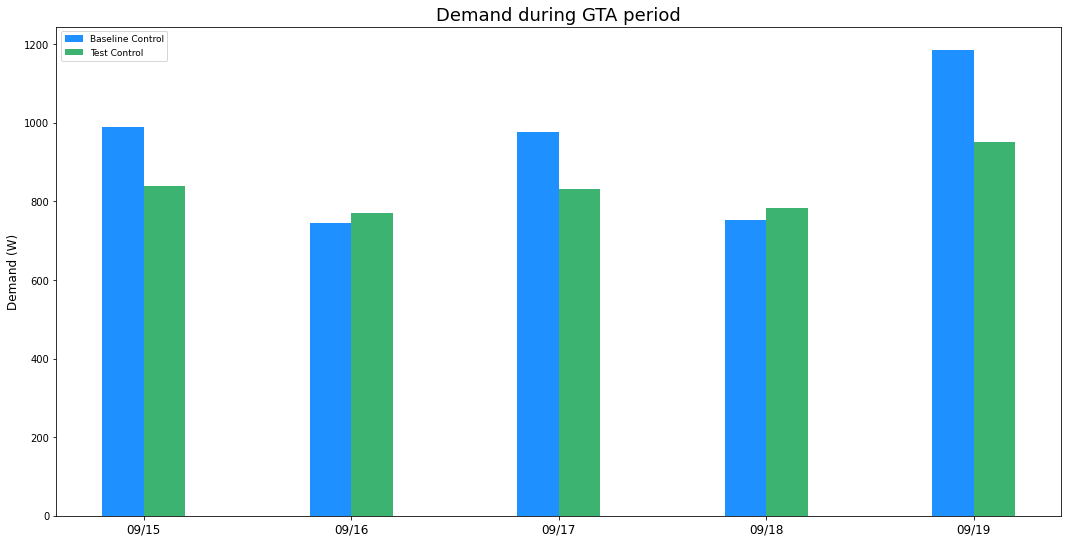

In [15]:
print(shed_1b)
db_plotting.shed_demand_plot(data25, shed_1a, shed_1b, 'Demand during GTA period', 'Demand (W)')

### SHIFT

In [16]:
data25['G36 Demand shift'] = data25['cooling_power [W]'] - data24['cooling_power [W]']

precool_1a = []
precool_1b = []
shift_oat = []
# define dates for the calculation
for day in range(15,20):    
    mask_1 = data25['date'] == datetime.date(2021, 9, day)
    #print(mask_1) 
        
    day_precool_1a = (data24['cooling_power [W]'][mask_1][precool_ts].mean())
    precool_1a.append(day_precool_1a)
    print(day_precool_1a)
    day_precool_1b = (data25['cooling_power [W]'][mask_1][precool_ts].mean())
    precool_1b.append(day_precool_1b)
    
    
    shift_oat_mean=(data24['1B-OAT-1'][mask_1][precool_ts].mean())
    
    shift_oat.append(shift_oat_mean)
    
    

936.9282120947685
743.074032864852
776.3561972686739
752.8387359299302
1022.8603588592748


[839.1100297035274, 771.1036852812822, 831.7791331815941, 781.6152274588288, 949.6061529028864]
['09/15', '09/16', '09/17', '09/18', '09/19']
[954.5014486309403, 777.7929619084521, 824.3420084157041, 779.6619195955436, 1165.3663035040427]


/Users/huangwp/Documents/git/HIL-Sim/flexlab/test_data_analysis/db_plotting.py:105: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace = .2, wspace=.15)


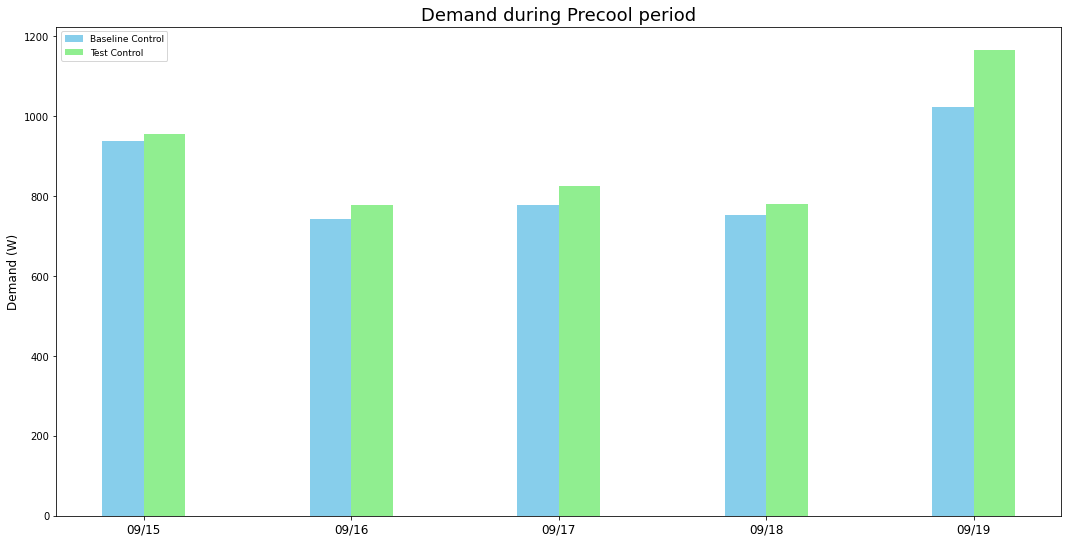

In [17]:
print(shed_1b)
db_plotting.precool_demand_plot(data25, precool_1a, precool_1b, 'Demand during Precool period', 'Demand (W)')

### Thermal comfort

/var/folders/31/7jjh3bzd6_d_tmg49kbcdsb40000gp/T/ipykernel_1373/2927749858.py:2: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace = .4, wspace=.15)


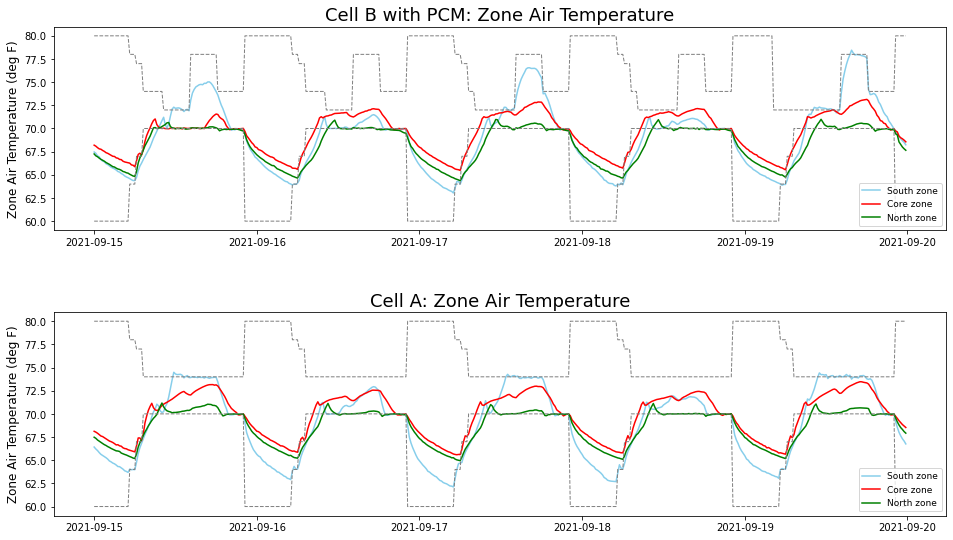

In [18]:
fig, (ax1, ax) = plt.subplots(nrows = 2, ncols = 1, constrained_layout=True, facecolor='w', edgecolor='k',figsize = (16,9))
fig.subplots_adjust(hspace = .4, wspace=.15)

ax1.plot(data25['1B-VAV3-Zn_Temp'], label = 'South zone', color = 'skyblue')
ax1.plot(data25['1B-VAV2-Zn_Temp'], label = 'Core zone', color = 'red')
ax1.plot(data25['1B-VAV1-Zn_Temp'], label = 'North zone', color = 'green')
ax1.plot(data25['1B-VAV3-OccupiedCoolingSetpt'], color = 'grey', linewidth= 1, linestyle = 'dashed')
ax1.plot(data25['1B-VAV3-OccupiedHeatingSetpt'], color = 'grey', linewidth= 1, linestyle = 'dashed')

ax.plot(data24['1A-VAV3-Zn_Temp'], label = 'South zone', color = 'skyblue')
ax.plot(data24['1A-VAV2-Zn_Temp'], label = 'Core zone', color = 'red')
ax.plot(data24['1A-VAV1-Zn_Temp'], label = 'North zone', color = 'green')
ax.plot(data24['1A-VAV3-OccupiedCoolingSetpt'], color = 'grey', linewidth= 1, linestyle = 'dashed')
ax.plot(data24['1A-VAV3-OccupiedHeatingSetpt'], color = 'grey', linewidth= 1, linestyle = 'dashed')

ax1.set_ylabel('Zone Air Temperature (deg F)', fontsize = 12)
ax.set_ylabel('Zone Air Temperature (deg F)', fontsize = 12)

ax1.set_title('Cell B with PCM: Zone Air Temperature', fontsize = 18)
ax.set_title('Cell A: Zone Air Temperature', fontsize = 18)

ax.legend(fontsize = 9, loc = 4)
ax1.legend(fontsize = 9, loc = 4)

In [19]:
data24 = data24.assign(nor_zat_deg = 'nor_zat_deg') 
#for i in range(len(data20.index)):

def zat_col(df_zat, df_cool_sp):
    df_zat = df_zat.apply(lambda x: (x-32)/1.8)
    df_cool_sp = df_cool_sp.apply(lambda x: (x-32)/1.8)
    
    df_zat_deg = df_zat - df_cool_sp
    df_zat_deg = df_zat_deg.apply(lambda x:0 if x <= 0 else x)
    return (df_zat_deg)

In [20]:
data24['nor_zat_deg'] = zat_col(data24['1A-VAV1-Zn_Temp'], data24['1A-VAV1-OccupiedCoolingSetpt'])
data24['cor_zat_deg'] = zat_col(data24['1A-VAV3-Zn_Temp'], data24['1A-VAV2-OccupiedCoolingSetpt'])
data24['sou_zat_deg'] = zat_col(data24['1A-VAV3-Zn_Temp'], data24['1A-VAV3-OccupiedCoolingSetpt'])

data25['nor_zat_deg'] = zat_col(data25['1B-VAV1-Zn_Temp'], data25['1B-VAV1-OccupiedCoolingSetpt'])
data25['cor_zat_deg'] = zat_col(data25['1B-VAV2-Zn_Temp'], data25['1B-VAV2-OccupiedCoolingSetpt'])
data25['sou_zat_deg'] = zat_col(data25['1B-VAV3-Zn_Temp'], data25['1B-VAV3-OccupiedCoolingSetpt'])

#data22['nor_zat_deg'] = zat_col(data22['VAV: North Zone Room Air Temperature'], data22['Tcool_SP'])
#data22['cor_zat_deg'] = zat_col(data22['VAV: Core Zone Room Air Temperature'], data22['Tcool_SP'])
#data22['sou_zat_deg'] = zat_col(data22['VAV: South Zone Room Air Temperature'], data22['Tcool_SP'])

#data23['nor_zat_deg'] = zat_col(data23['VAV: North Zone Room Air Temperature'], data23['Tcool_SP'])
#data23['cor_zat_deg'] = zat_col(data23['VAV: Core Zone Room Air Temperature'], data23['Tcool_SP'])
#data23['sou_zat_deg'] = zat_col(data23['VAV: South Zone Room Air Temperature'], data23['Tcool_SP'])

#data24['nor_zat_deg'] = zat_col(data24['VAV: North Zone Room Air Temperature'], data24['Tcool_SP'])
#data24['cor_zat_deg'] = zat_col(data24['VAV: Core Zone Room Air Temperature'], data24['Tcool_SP'])
#data24['sou_zat_deg'] = zat_col(data24['VAV: South Zone Room Air Temperature'], data24['Tcool_SP'])

In [21]:
#print(data20['nor_zat_deg'], data23['nor_zat_deg'])

In [22]:
def calc_stats(df, df_temp):
   
    overshoot = []
    mean = []
    median = []
    std = []
    oc_st = datetime.time(7,0,0)
    oc_en = datetime.time(19,0,0)

    oc_time = ((df['time'] >= oc_st) & (df['time'] <= oc_en))

    #print(df_temp, df['Tcool_SP'])
        
    for day in range(15, 20):    
        mask_1 = data25['date'] == datetime.date(2021, 9, day)
        daily_mean = df_temp[mask_1][oc_time].mean()
        daily_median = df_temp[mask_1][oc_time].median()
        #print('Variance', df[df[i] > target[i]].var())
        daily_std = df_temp[mask_1][oc_time].std()
        
        mean.append(daily_mean)
        median.append(daily_median)
        std.append(daily_std)
        
    #for i in range(len(df.index)):
        #if (df['time'][i] <= oc_en) & (df['time'][i] >= oc_st):
        #print(df_temp[i], df['Tcool_SP'][i], df_temp[i] - df['Tcool_SP'][i])
        daily_shoot = sum(df_temp[mask_1][oc_time]*.25)
        counter = sum(df_temp[mask_1][oc_time]>0)
        overshoot.append(daily_shoot)
        
        #print(day)
    #print(mean, median, std)
    
    return(overshoot, mean, median, std)

In [23]:
print(data24.columns)

Index(['desk1_plug_power', 'desk2_plug_power', 'desk3_plug_power',
       'desk4_plug_power', 'desk5_plug_power', 'desk6_plug_power',
       'desk3_light_power', 'desk4_light_power', 'desk2_light_power',
       'desk1_6_light_power', 'desk5_light_power', '1A-VAV1-Zn_Temp',
       '1A-VAV2-Zn_Temp', '1A-VAV3-Zn_Temp', '1A-VAV1-OccupiedCoolingSetpt',
       '1A-VAV1-UnoccupiedCoolingSetpt', '1A-VAV1-OccupiedHeatingSetpt',
       '1A-VAV1-UnoccupiedHeatingSetpt', '1A-VAV2-OccupiedCoolingSetpt',
       '1A-VAV2-UnoccupiedHeatingSetpt', '1A-VAV2-UnoccupiedCoolingSetpt',
       '1A-VAV2-OccupiedHeatingSetpt', '1A-VAV3-OccupiedCoolingSetpt',
       '1A-VAV3-UnoccupiedHeatingSetpt', '1A-VAV3-UnoccupiedCoolingSetpt',
       '1A-VAV3-OccupiedHeatingSetpt', '1A-El-AHU', '1A-El-CHWP', '1A-El-HWP',
       '1A-El-Exhaust Fan', '1A-Th-Chilled Water', '1B-OAT-1',
       '1A-MidZone-TCS6-DBT', '1A-NorthZone-DBT', '1A-WindowZone-TCS7-DBT',
       '1A-VAV1-DischargeAirTemp', '1A-VAV2-DischargeAirTemp',
 

In [24]:
data24_nor_zat_deg, data24_nor_mean, data24_nor_median, data24_nor_std = calc_stats(data24, data24['nor_zat_deg'])
data24_cor_zat_deg, data24_cor_mean, data24_cor_median, data24_cor_std = calc_stats(data24, data24['cor_zat_deg'])
data24_sou_zat_deg, data24_sou_mean, data24_sou_median, data24_sou_std = calc_stats(data24, data24['sou_zat_deg'])

data25_nor_zat_deg, data25_nor_mean, data25_nor_median, data25_nor_std = calc_stats(data25, data25['nor_zat_deg'])
data25_cor_zat_deg, data25_cor_mean, data25_cor_median, data25_cor_std = calc_stats(data25, data25['cor_zat_deg'])
data25_sou_zat_deg, data25_sou_mean, data25_sou_median, data25_sou_std = calc_stats(data25, data25['sou_zat_deg'])


In [25]:
print(data24_nor_zat_deg, data24_nor_mean, data25_nor_median, data25_nor_std)

[0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0]


In [26]:
scenario_dict = {}
scenario_dict[1] = calc_stats(data24, data24['nor_zat_deg'])
scenario_dict[2] = calc_stats(data24, data24['cor_zat_deg'])
scenario_dict[3] = calc_stats(data24, data24['sou_zat_deg'])

scenario_dict[4] = calc_stats(data25, data25['nor_zat_deg'])
scenario_dict[5] = calc_stats(data25, data25['cor_zat_deg'])
scenario_dict[6] = calc_stats(data25, data25['sou_zat_deg'])

In [27]:
scenario_dict = {'data24': {"nor": calc_stats(data24, data24['nor_zat_deg']),
                            "cor": calc_stats(data24, data24['cor_zat_deg']), 
                            "sou": calc_stats(data24, data24['sou_zat_deg'])}, 
                 
                 'data25': {"nor": calc_stats(data25, data25['nor_zat_deg']),
                            "cor": calc_stats(data25, data25['cor_zat_deg']), 
                            "sou": calc_stats(data25, data25['sou_zat_deg'])}}

In [28]:
print(scenario_dict['data25']['sou'])
print(scenario_dict['data25']['sou'][0][1:5])

([0.1736111111111116, 0.0, 0.1277777777777782, 0.0, 0.40833333333333766], [0.01417233560090707, 0.0, 0.010430839002267609, 0.0, 0.03333333333333369], [0.0, 0.0, 0.0, 0.0, 0.0], [0.03718249027343914, 0.0, 0.035656552395471816, 0.0, 0.05846545883291494])
[0.0, 0.1277777777777782, 0.0, 0.40833333333333766]


In [29]:
print(sum(data24_nor_zat_deg), sum(data25_nor_zat_deg))
print(sum(data24_cor_zat_deg), sum(data25_cor_zat_deg))
print(sum(data24_sou_zat_deg), sum(data25_sou_zat_deg))

0.0 0.0
0.7333333333333281 0.005555555555556424
0.7333333333333281 0.7097222222222275


['09/15', '09/16', '09/17', '09/18', '09/19']
[datetime.date(2021, 9, 15) datetime.date(2021, 9, 16)
 datetime.date(2021, 9, 17) datetime.date(2021, 9, 18)
 datetime.date(2021, 9, 19)]
[0.0, 0.0, 0.0, 0.0, 0.0]


/Users/huangwp/Documents/git/HIL-Sim/flexlab/test_data_analysis/db_plotting.py:142: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace = .2, wspace=.15)
/Users/huangwp/Documents/git/HIL-Sim/flexlab/test_data_analysis/db_plotting.py:214: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels, fontsize = 12)


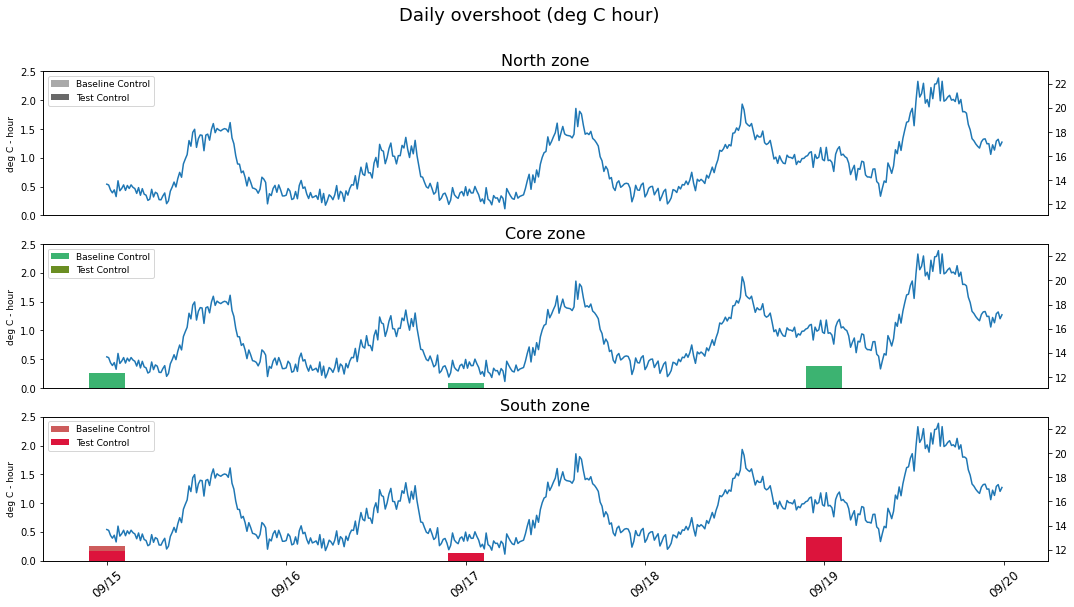

In [30]:
# key for metrics to be plotted in the scenario dictionary; {1:'overshoot', 2:'mean', 3:'median', 4:'std_dev'}
title_dict = {1: 'Daily overshoot (deg C hour)', 2:'Daily overshoot (mean)', 3:'Daily overshoot (median)' , 4:'Daily overshoot (standard deviation)'}
ylabel = {1: 'deg C - hour', 2: 'deg C', 3: 'deg C', 4: 'deg C'}
db_plotting.thermal_comfort_plot(data24, scenario_dict['data24']['nor'], scenario_dict['data25']['nor'], 
                                 scenario_dict['data24']['cor'], scenario_dict['data25']['cor'], 
                                 scenario_dict['data24']['sou'], scenario_dict['data25']['sou'],
                                 scenario_dict, 0, ylabel[1], title_dict[1])

In [31]:
def demand_plot(data, list_1, list_2, list_3, list_4, title, y_label):
    fig, (ax) = plt.subplots(nrows = 1, ncols = 1, constrained_layout=True, facecolor='w', edgecolor='k',figsize = (18,9))
    fig.subplots_adjust(hspace = .2, wspace=.15)

    inp_day = data['date'].unique() # capture unique dates from the date column
    inp_day = inp_day.tolist() #convert to a list
    #print(inp_day)
    # create labels for each date of the test
    labels = []
    labels1 = []
    for i in range(0,len(inp_day)):
        labels.append(inp_day[i].strftime('%m/%d'))

    for i in range(0,len(inp_day)-1):
        labels1.append(inp_day[i].strftime('%m/%d'))

    x = np.arange(len(labels))
    print(labels)
    print(list_2)
    width = .2

    ax.bar(x-width*.5, list_1, width = width, label='Shed Baseline', color = 'darkviolet')
    ax.bar(x-width*.5, np.array(list_3)*-1, width = width, label='Precool Baseline', color = 'thistle')
    ax.bar(x+width*.5, list_2, width = width, label='Shed Test', color = 'orange')
    ax.bar(x+width*.5, np.array(list_4)*-1, width = width, label='Precool Test', color = 'khaki')
    ax.axhline(linewidth=1, color='black')

    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels[0:len(labels)], fontsize = 12)
    ax.set_title(title, fontsize = 18)
    ax.set_ylabel(y_label, fontsize = 12)
    ax.legend(fontsize = 9, loc = 2)

['09/15', '09/16', '09/17', '09/18', '09/19']
[839.1100297035274, 771.1036852812822, 831.7791331815941, 781.6152274588288, 949.6061529028864]


/var/folders/31/7jjh3bzd6_d_tmg49kbcdsb40000gp/T/ipykernel_1373/4120796508.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace = .2, wspace=.15)


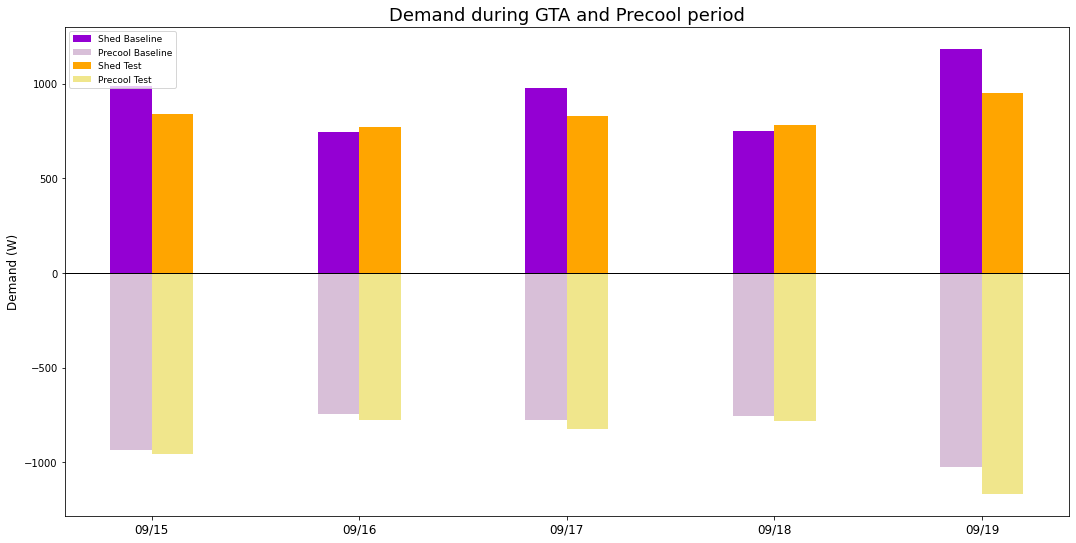

In [32]:
demand_plot(data25, shed_1a, shed_1b, precool_1a, precool_1b, 'Demand during GTA and Precool period', 'Demand (W)')

In [33]:
df_4 = pd.DataFrame([]) ##### enter list of metrics you want in this dataframe
df_4 = df_4.transpose()
df_4.columns=['demand_dec','demand_inc','net_energy', 'max_demand', 'dates', 'Test group', 'OAT','peak_OAT']





ValueError: Length mismatch: Expected axis has 0 elements, new values have 8 elements

In [ ]:

df_4['OAT']=pd.to_numeric(df_4['OAT'])
df_4['demand_dec']=pd.to_numeric(df_4['demand_dec'])
slope, intercept, r_value1, p_value1, std_err = stats.linregress(df_4['OAT'],
                                                               df_4['demand_dec'])

print(p_value, r_value)

sns.regplot(x="OAT", y="demand_dec", ci=None, 
            data=inp_df, marker="+",color="b", label='Field Test',
            line_kws={'label':"R^2={0:.3f}".format(r_value1*r_value1)},ax=ax2)







ax1.set_ylabel('Simulated DDI, [W/ft^2]')
ax1.set_xlabel('Avg. OAT during Event Hours ($^\circ$F)')
ax1.legend()
ax1.set_xlim(55,95)
ax1.set_ylim(0,0.8)

